<a href="https://colab.research.google.com/github/Alfikriangelo/MachineLearningTasks/blob/main/6thWeekTask/Density_Based_Spatial_Clustering_of_Applications_with_Noise_Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install kneed

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from scipy.cluster.hierarchy import linkage
from kneed import KneeLocator
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler

In [14]:
# Load the data
data = pd.read_excel('sample_data/Online Retail.xlsx', nrows=20000)

# Select only numeric columns
data_numeric = data.select_dtypes(include=[np.number])

# Fill NaN values with the mean of each column
data_numeric_filled = data_numeric.fillna(data_numeric.mean())

# Get the values without NaNs
X = data_numeric_filled.values


X = StandardScaler().fit_transform(X)


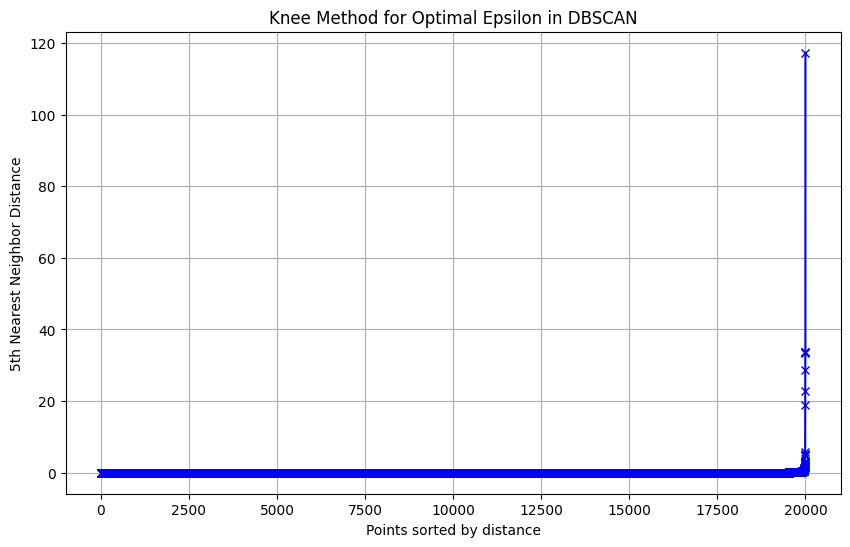

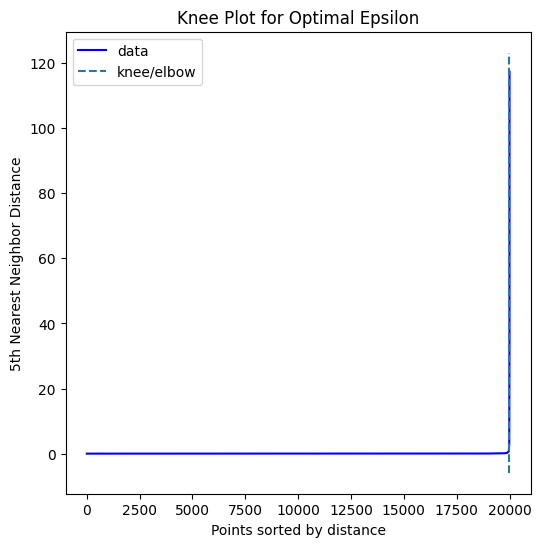

Nilai epsilon optimal yang ditemukan: 33.85191624485769


In [35]:
# Step 1: Determine optimal epsilon using Knee method (adapted for DBSCAN)
def plot_elbow_method(data):
    # Calculate distance to the 5th nearest neighbor for each point
    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances[:, 4], axis=0)  # 5th nearest neighbor distance

    # Plot the knee/elbow to determine optimal epsilon
    plt.figure(figsize=(10, 6))
    plt.plot(distances, 'bx-')
    plt.xlabel("Points sorted by distance")
    plt.ylabel("5th Nearest Neighbor Distance")
    plt.title("Knee Method for Optimal Epsilon in DBSCAN")
    plt.grid()
    plt.show()

    # Find knee point using KneeLocator
    kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    optimal_epsilon = distances[kneedle.elbow]


    # Plot knee point
    kneedle.plot_knee()
    plt.xlabel("Points sorted by distance")
    plt.ylabel("5th Nearest Neighbor Distance")
    plt.title("Knee Plot for Optimal Epsilon")
    plt.show()

    return optimal_epsilon

# Get optimal epsilon
optimal_epsilon = plot_elbow_method(X)

# Menampilkan nilai epsilon optimal pada konsol
print("Nilai epsilon optimal yang ditemukan:", optimal_epsilon)


In [27]:
# Step 2: Apply DBSCAN clustering with the chosen epsilon
min_samples = 5
dbscan = DBSCAN(eps=1, min_samples=5)
labels = dbscan.fit_predict(X)


In [28]:
# Step 3: Filter out noise points for evaluation and visualization
mask = labels != -1
X_filtered = X[mask]
labels_filtered = labels[mask]


In [29]:
# Calculate Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(X_filtered, labels_filtered) if len(set(labels_filtered)) > 1 else "Not applicable"
davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered) if len(set(labels_filtered)) > 1 else "Not applicable"

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.8034692965017955
Davies-Bouldin Index: 0.18522154650550254


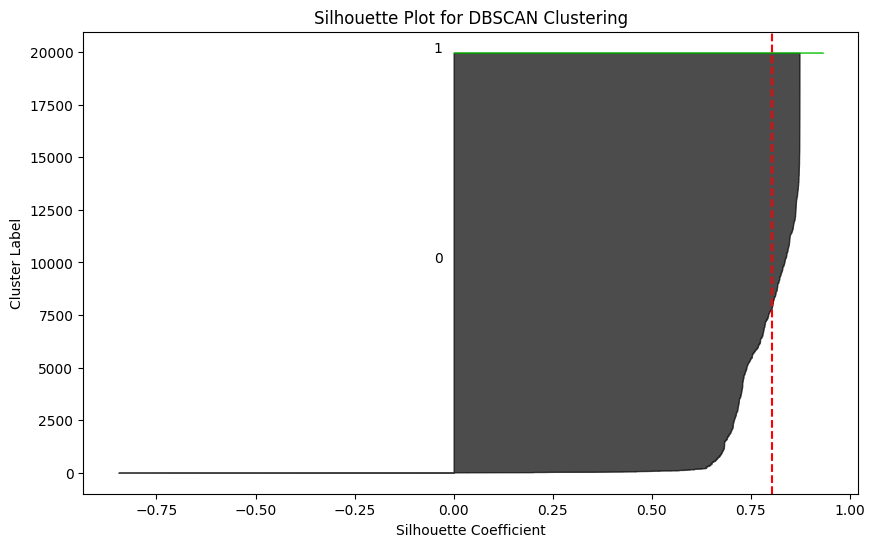

In [30]:
# Step 4: Silhouette Plot
silhouette_vals = silhouette_samples(X_filtered, labels_filtered)
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
unique_labels = np.unique(labels_filtered)
colors = cm.nipy_spectral(unique_labels.astype(float) / len(unique_labels))

for i, label in enumerate(unique_labels):
    silhouette_vals_label = silhouette_vals[labels_filtered == label]
    silhouette_vals_label.sort()
    y_upper += len(silhouette_vals_label)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_vals_label,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * len(silhouette_vals_label), str(label))
    y_lower = y_upper

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.title("Silhouette Plot for DBSCAN Clustering")
plt.show()

In [31]:
# Step 5: Visualization for Davies-Bouldin Index - Cluster Centroids and Distances
centroids = np.array([X_filtered[labels_filtered == label].mean(axis=0) for label in unique_labels])

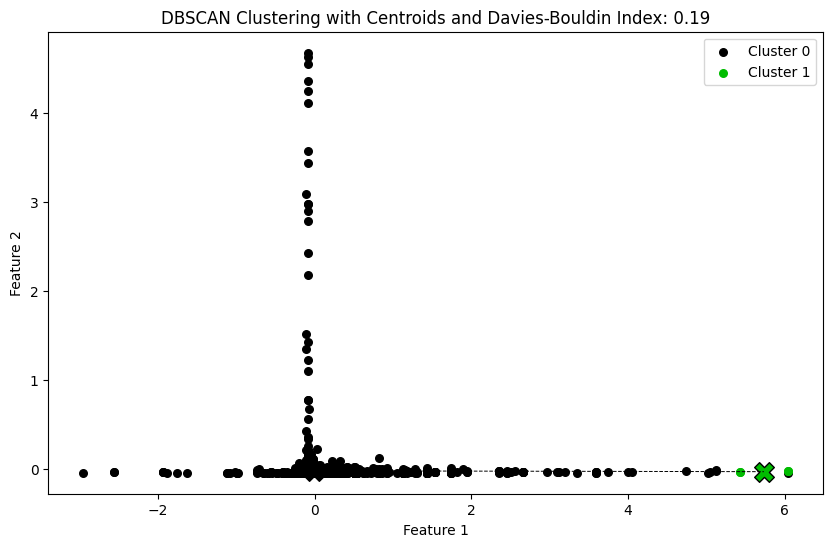

In [32]:
# Scatter plot of clusters with centroids and inter-centroid distances
plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    cluster_points = X_filtered[labels_filtered == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=30, color=colors[i], label=f"Cluster {label}")
    plt.scatter(centroids[i, 0], centroids[i, 1], s=200, c=[colors[i]], marker='X', edgecolor='k')

# Plot lines between centroids to show distances relevant to Davies-Bouldin Index
for i, c1 in enumerate(centroids):
    for j, c2 in enumerate(centroids):
        if i < j:  # Avoid duplicating lines
            plt.plot([c1[0], c2[0]], [c1[1], c2[1]], 'k--', linewidth=0.7)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"DBSCAN Clustering with Centroids and Davies-Bouldin Index: {davies_bouldin:.2f}")
plt.legend()
plt.show()